# Introduction

- This script need the cleaned version of _roads2 data and raw BMMS_overview data. 
- WBSIM_Lab1b also need to be inside the Jupyter Notebook file to have the shapefile from the (WBSIM_Lab1b\gis\gadm\BGD_adm0) the shapefile name is BGD_adm0
- timeit, shapefile and shapely library should also be installed in the Jupyter Notebook (use !pip install "name_of_library" to do so)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import re
#import seaborn as sns
import timeit

import shapefile as shp
from shapely.geometry import Point, Polygon

#!pip install pyshp

## Load the Excel Files to the Dataframe

In [2]:
path ='D:\Download\WBSIM_Lab1b\infrastructure\BMMS_overview.xlsx'

df = pd.read_excel(path,index_col=None, header=0)

df_clean_0 = df#.drop_duplicates(subset=['lon','lat'], keep=False)


print('Total data before drop duplicates:' ,len(df),'Data')
print('Total data after drop duplicates:' ,len(df_clean_0),'Data')

Total data before drop duplicates: 21407 Data
Total data after drop duplicates: 21407 Data


## Load the Shapefile from the GIS data

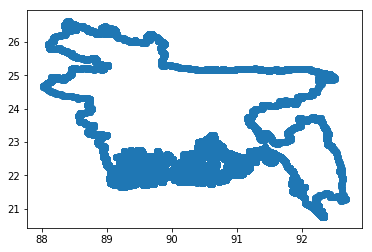

In [3]:
sf0 = shp.Reader("D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab1b\gis\gadm\BGD_adm0")
#sf1 = shp.Reader("D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab1b\gis\gadm\BGD_adm1")
#sf2 = shp.Reader("D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab1b\gis\gadm\BGD_adm2")
#sf3 = shp.Reader("D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab1b\gis\gadm\BGD_adm3")

for shape in sf0.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.scatter(x,y)
plt.show()

In [13]:
sf0.bbox[3]

26.634399414062756

## Convert Shapefile into List

In [4]:
# Function to get the shape file value from GIS
def convert_shp_to_list (sf,num_name):
    
    shps_name = sf.records()
    shps_coor = [s.points for s in sf.shapes()]
    
    name_shape = []
    coor_shape_lat = []
    coor_shape_lon = []
    
    l = {}
    counter = 0
    for i in range(len(shps_name)):
        name_shape.append(shps_name[i][num_name])
        #coor_shape.append(shps_coor[i])
        
        for a in range(len(shps_coor[i])):
            l[counter] = {'Name':name_shape[i],'Longitude':shps_coor[i][a][0],'Latitude':shps_coor[i][a][1]}
            coor_shape_lat.append(shps_coor[i][a][1])
            coor_shape_lon.append(shps_coor[i][a][0])
            
            counter = counter+a
            
        #j = pd.DataFrame(l)
        #j = j.transpose()
    
    return name_shape,shps_coor,coor_shape_lat,coor_shape_lon,l#,j

In [5]:
#shape_dataframe0, 
name_shp0, coor_shp0, coor_shp_lat0, coor_shp_lon0, l = convert_shp_to_list(sf0,2)

## Swapped Lattitude and Longitude data

In [6]:
# Count how many swapped values data 
len(df_clean_0[ (df_clean_0['lat'] > 80)])
print("Swapped Coordinates identified",len(df_clean_0[ (df_clean_0['lat'] > 80)]))

Swapped Coordinates identified 15


In [7]:
# Swap the bridge coordinate
swapped_bridge_index  = (df_clean_0[(df_clean_0['lat'] > 80)]).index

df_clean_0['empty_data'] = 0

df_clean_0.loc[swapped_bridge_index,'empty_data'] = (df_clean_0[ (df_clean_0['lat'] > 80)]['lon'])
df_clean_0.loc[swapped_bridge_index,'lon'] = (df_clean_0[ (df_clean_0['lat'] > 80)]['lat'])
df_clean_0.loc[swapped_bridge_index,'lat'] = (df_clean_0[ (df_clean_0['lat'] > 80)]['empty_data'])


## Check the real boundaries of Bangladesh with its geo shapefile
(This code run quite slow!!!!!!)

In [8]:
# Detecting the outliers outside the real "boundaries" of the Bangladesh by creating polygon from the shapefile (GIS BGD_adm0) 
# and then compare each bridge points whether it is outside of the polygon or not

index_error = []
coords = coor_shp0[0]
poly = Polygon(coords)

# time calculation time
start = timeit.default_timer()

for i in range(len(df_clean_0)):
    # Create Point objects
    point_check = Point(df_clean_0['lon'][i], df_clean_0['lat'][i])
    #for a in range(len(coor_shp0)):
    if not(point_check.within(poly)):
        index_error.append(i)

stop = timeit.default_timer()

print('Out-of-Bounds Identified:', len(index_error))
print('time elapsed for error detection: ', stop-start)

KeyboardInterrupt: 

In [ ]:
df_clean_0.ix[index_error,'empty_data'] = True
df_clean_0.ix[index_error,'lat'] = np.nan
df_clean_0.ix[index_error,'lon'] = np.nan

## Smoothing with Mean and Standard Deviation

In [ ]:
# Smoothing some of the coordinates by mean and standard deviation of the name of division

df_clean_0.sort_values(by=['division'])
Circle_data_counts = df_clean_0['division'].value_counts()
#Circle_data_counts

ErLat = []
ErLon = []
Threshold = 4
ep = 0

for i in range(len(Circle_data_counts)):
    
    sp = ep
    ep = ep + Circle_data_counts[i]
    
    roadFrame = df_clean_0[sp:ep]
    
    meanLat = roadFrame['lat'].mean()
    meanLon = roadFrame['lon'].mean()
    
    stdLat = roadFrame['lat'].std()
    stdLon = roadFrame['lon'].std()
    
    ErrorLat = (roadFrame['lat'] > (meanLat + stdLat*Threshold)) | (roadFrame['lat'] < (meanLat - stdLat*Threshold))
    ErrorLon = (roadFrame['lon'] > (meanLon + stdLon*Threshold)) | (roadFrame['lon'] < (meanLon - stdLon*Threshold))
    
    ErrorIndexLat = roadFrame[ErrorLat].index
    ErrorIndexLon = roadFrame[ErrorLon].index
    
    ErLat.append(ErrorIndexLat)
    ErLon.append(ErrorIndexLon)
    
ErLonList = [y for x in ErLon for y in x]
ErLatList = [y for x in ErLat for y in x]
print('amount of errative longitude values found: ', len(ErLonList))
print('amount of errative lattitude values found: ', len(ErLatList))

# replace errative parts with NaN
df_clean_0.loc[ErLonList,'lon'] = np.nan
df_clean_0.loc[ErLatList,'lat'] = np.nan

## Interpolate all outliers

In [ ]:
# interpolate longitude and latitude with nearest method

df_clean_0['lon'] = df_clean_0['lon'].interpolate(method='nearest')
df_clean_0['lat'] = df_clean_0['lat'].interpolate(method='nearest')

## Pull the bridges coordinates into the "clean" road 

In [ ]:
#path = 'D:\Jupyter_File\Advanced_Discrete_Cleaning\WBSIM_Lab1b\infrastructure\_roads2.csv'
#df_road = pd.read_csv(path,index_col=None, header=0)

In [ ]:
#df_road.sort_values(by=['road'])
#road_data_counts = df_road['road'].value_counts()

## convert to xlxs file

In [ ]:
writer = pd.ExcelWriter('BMMS_overview.xlsx', engine='xlsxwriter')

#Convert the dataframe to an XlsxWriter Excel object.
df_clean_0.to_excel(writer, sheet_name='BMMS_overview',index=False)

#Close the Pandas Excel writer and output the Excel file.
writer.save()